## Laden der Text Daten 

In [54]:
import os, gzip
import pandas as pd
import numpy as np
import urllib.request

DATADIR = "data"

if not os.path.exists(DATADIR): 
    os.mkdir(DATADIR)

file_name = os.path.join(DATADIR, 'bundestags_parlamentsprotokolle.csv.gzip')
if not os.path.exists(file_name):
    url_data = 'https://www.dropbox.com/s/1nlbfehnrwwa2zj/bundestags_parlamentsprotokolle.csv.gzip?dl=1'
    urllib.request.urlretrieve(url_data, file_name)

df = pd.read_csv(gzip.open(file_name), index_col=0).sample(frac=1)

alle_sprecher = df.sprecher.unique()
parteien = df.partei.unique()
partei_farben = {'cducsu':'black', 'linke':'purple', 'spd':'red', 'gruene':'green', 'fdp':'yellow'}

df[:10]

,sitzung,wahlperiode,sprecher,text,partei
29123,63,18,Klaus-Peter Flosbach,"Meine Damen und Herren, in den letzten sechs J...",cducsu
24846,17,18,Armin Schuster,– Von Heiko und Thomas auch. – So etwas konnte...,cducsu
10571,125,17,Dr. Rainer Stinner,"- Ich bin noch nicht ganz zu Ende, warte aber ...",fdp
13269,153,17,Sören Bartol,Sehr geehrter Herr Präsident! Liebe Kolleginne...,spd
217,6,17,Dr. Rainer Stinner,Wir alle wissen um die Bedeutung der polnische...,fdp
19046,212,17,Richard Pitterle,"Ich meine, die schwarz-gelbe Koalition ist auc...",linke
21456,234,17,Ralph Brinkhaus,"Der zweite Problemblock liegt darin, dass es L...",cducsu
20027,220,17,Jürgen Hardt,"Ich bin der Meinung, dass sich auch die Öffent...",cducsu
11606,137,17,Henning Otte,"Meine sehr verehrten Damen und Herren, der Sol...",cducsu
23200,250,17,Petra Müller,Lärmschutz ist ein ernster und wichtiger Aspek...,fdp


In [55]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import warnings

def train(texts, party, num_words=1e5):
    '''
    Eine Funktion, die gegeben Texte und Labels einen Klassifier trainiert
    '''
    stopwords = [w.strip() for w in open("data/stopwords.txt").readlines()]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Eine Machine Learning Pipeline um Bag-of-Words Vectors zu erstellen aus Texten
        text_clf = Pipeline([('vect', TfidfVectorizer(stop_words=stopwords, max_features=int(num_words))),
                            ('clf', SGDClassifier(loss='log'))])
        # some hyperparameters
        parameters = {
            'vect__ngram_range': [(1, 1)],
            'clf__alpha': (np.logspace(-5, -1, 5)).tolist()
        }
        # perform gridsearch to get the best regularizer
        clf = GridSearchCV(text_clf, parameters, cv=2, n_jobs=-1,verbose=0)
        clf.fit(texts, party)

    return clf


## Trainieren eines linearen Klassifiers

In [56]:
# Erst nehmen wir einige Daten beiseite, um das Model darauf spaeter testen zu koennen
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['partei'], test_size=0.5)

# Jetzt trainieren wir den Klassifier
clf = train(train_data, train_labels)

# Vorhersage auf Trainings Daten

In [58]:
train_predictions = clf.predict(train_data)
print(classification_report(train_predictions, train_labels))

             precision    recall  f1-score   support

     cducsu       1.00      0.95      0.97      8412
        fdp       0.88      1.00      0.94      1458
     gruene       0.96      1.00      0.98      3023
      linke       0.98      0.99      0.99      3001
        spd       0.97      0.98      0.97      5945

avg / total       0.97      0.97      0.97     21839



# Vorhersage auf Test Daten

In [59]:
test_predictions = clf.predict(test_data)
print(classification_report(test_predictions, test_labels))

             precision    recall  f1-score   support

     cducsu       0.78      0.58      0.66     10924
        fdp       0.11      0.51      0.18       361
     gruene       0.28      0.49      0.36      1803
      linke       0.48      0.58      0.52      2525
        spd       0.49      0.46      0.48      6227

avg / total       0.61      0.54      0.56     21840



## Confusion Matrix

In [60]:
print(confusion_matrix(test_labels, test_predictions))

[[6288   84  200  207 1257]
 [1031  183   57   84  371]
 [ 818   31  883  413  989]
 [ 554   14  314 1460  724]
 [2233   49  349  361 2886]]


# Testen des Modells mit eigenem text

In [71]:
text = "Neoliberale Heuschrecken Banker sind schlecht für den Sozialstaat."
clf.predict([text])

array(['linke'],
      dtype='<U6')

In [70]:
text = "Wachstum und Sicherheit sind wichtig für glückliche Familien"
clf.predict([text])

array(['cducsu'],
      dtype='<U6')

## Mit mehr Regeln kann der Classifier bessere Vorhersagen machen

In [61]:
# wir trainieren ein Modell mit 10, 100, ... 1.000.000 Woertern
anzahl_woerter = [10, 100, 1000, 10000, 100000]
# hier speichern wir, wie gut das Modell war
vorhersagequalitaet = []

for aw in anzahl_woerter:
    clf_ = train(train_data, train_labels, aw)
    test_predictions = clf_.predict(test_data)
    vorhersagequalitaet.append(accuracy_score(test_labels, test_predictions))

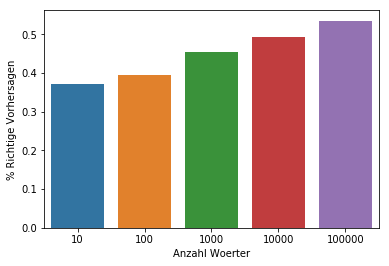

In [62]:
import seaborn as sns
from matplotlib import pylab
%matplotlib inline
sns.barplot(anzahl_woerter,vorhersagequalitaet)
pylab.xlabel("Anzahl Woerter")
pylab.ylabel("% Richtige Vorhersagen")


## Download eines Zeitungsartikels

In [63]:
import urllib.request
from readability.readability import Document

url = "http://www.spiegel.de/politik/ausland/muss-deutschland-jetzt-milliarden-an-polen-zahlen-a-1167144.html"
html = urllib.request.urlopen(url).read()
readable_article = Document(html).summary()
readable_title = Document(html).short_title()


## Klassifizierung des Zeitungsartikels

Zeitungsartikel: Muss Deutschland jetzt Milliarden an Polen zahlen?


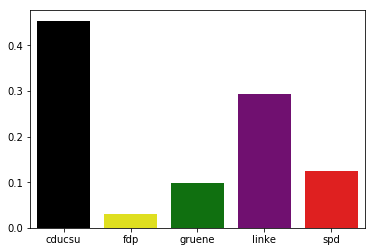

In [64]:
prediction = clf.predict_proba([readable_article])

print("Zeitungsartikel: {}".format(readable_title))

import seaborn as sns
%matplotlib inline
sns.barplot(clf.best_estimator_.steps[1][1].classes_, prediction.flatten(), palette=[partei_farben[p] for p in clf.classes_])

# Wordcloud wichtiger Wörter für jede Partei

*********************
Partei cducsu benutzt haeufig:
christlich, wettbewerbsfähigkeit, kernenergie, asylbewerber, christen, richtigen, währung, stabilität, flüchtlingskrise, dankeschön


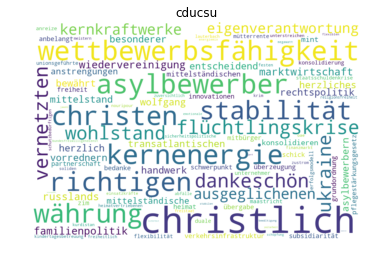

*********************
Partei fdp benutzt haeufig:
liberaler, zuwanderungssteuerung, unimog, sharma, verwaltungsmodernisierung, hefen, energieeffizienzstandards, zwangsquote, fahrausbildung, schuldenbergen


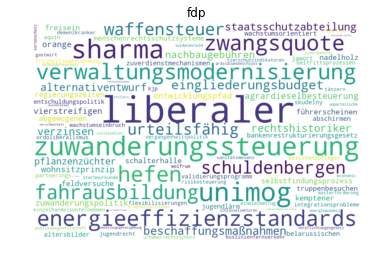

*********************
Partei gruene benutzt haeufig:
garantierente, klimakrise, tisa, leiharbeitskräfte, finanzaufsichtsbehörde, mindestniveau, immigranten, wehrbericht, einwanderinnen, vorbescheid


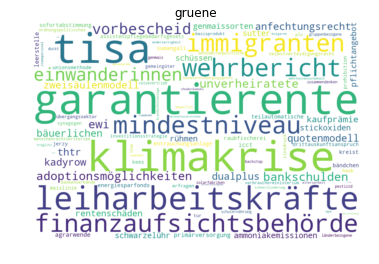

*********************
Partei linke benutzt haeufig:
südens, erwerbslosen, profite, erwerbslose, sozialabbau, waffenexporte, kurdinnen, jüdinnen, palästinenserinnen, vermögensmillionäre


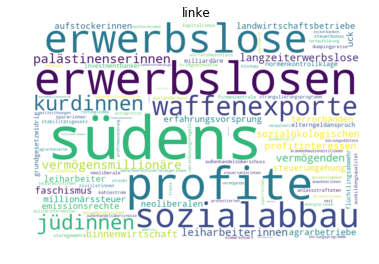

*********************
Partei spd benutzt haeufig:
sozialdemokratische, atomenergie, rüstungskontrolle, familienarbeitszeit, kernarbeitsnormen, ganztagsschulen, dat, rentensysteme, zivilbeschäftigten, arbeitnehmerrechte


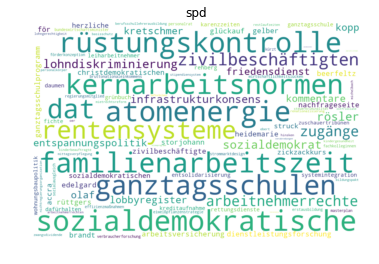

In [65]:
from wordcloud import WordCloud

def generate_wordcloud(text, party):

    # Generate a word cloud image
    wordcloud = WordCloud(collocations=False,background_color='white',width=1200, height=800).generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(party)
    plt.axis("off")
    plt.show()


# anzahl der top woerter pro partei:
top_what = 100
bow_vectors = clf.best_estimator_.steps[0][1].transform(df.text)
idx2words = {k:v for v,k in clf.best_estimator_.steps[0][1].vocabulary_.items()}
for party in np.unique(df['partei']):
    this_party = (df['partei'] == party).values * 2 - 1
    word_covariance = bow_vectors.T.dot(this_party).argsort()
    top_words = [idx2words[widx] for widx in word_covariance[-top_what:][::-1]]
    print("*********************\nPartei {} benutzt haeufig:\n{}".format(party, ", ".join(top_words[:10])))
    generate_wordcloud(" ".join([" ".join([w]*c) for w,c in zip(top_words, range(top_what,0,-1))]), party)
    

# Bist du besser als das ML Modell? 

In [66]:
# Wir ziehen 5 zufaellige Beispiele, die weniger als 2000 Buchstaben haben (damit man's noch durchlesen kann)
samples = df[df.text.apply(len) < 2000].sample(5)
vorhersage_mensch = []
vorhersage_maschine = clf.predict(samples.text)
tatsaechliche_partei = samples.partei.tolist()

for idx, text in enumerate(samples.text):
    print("================================")
    print(text)
    print('------------------------------------')
    print("Von welcher Partei ist dieser Text? Wähle aus {}".format(clf.classes_))
    vorhersage_mensch.append(input())
    print("*****************************")
    print("Deine Vorhersage: {}".format(vorhersage_mensch[-1]))
    print("ML Vorhersage: {}".format(vorhersage_maschine[idx]))
    print("Tatsächliche Partei: {}".format(tatsaechliche_partei[idx]))
    print("================================")
    
print("Deine Vorhersage Metriken:")
print(classification_report(vorhersage_mensch, tatsaechliche_partei))

print("Die Vorhersage Metriken des ML Modells:")
print(classification_report(vorhersage_maschine, tatsaechliche_partei))

Wo kommt das Wachstum von morgen her? Wer heute nicht sät, kann morgen und übermorgen nicht ernten. Deshalb steigern wir die Forschungsausgaben beträchtlich. Es wurde gerade von Frau Nestle behauptet, die Mittel für die Energieforschung gingen zurück. Ich weiß ja nicht, ob Sie den rot-grünen Haushalt von 2005 gelesen haben. Bei unserem Haushalt jedenfalls ist das Gegenteil der Fall: Wir steigern die Ausgaben für die Energieforschung von 2011 bis 2014 auf 3,5 Milliarden Euro. Das entspricht, verglichen mit der entsprechenden Periode unter Rot-Grün, einer Steigerung um 75 Prozent. Dennoch stellen Sie sich hier hin und sagen, wir würden weniger Geld für die Energieforschung ausgeben. Also, entweder behaupten Sie das wider besseres Wissen, oder Sie versuchen, die Leute in die Irre zu führen.

Von Bedeutung sind auch weitere Technologien, im Energiebereich, aber auch in anderen Bereichen. Ich kann nur die Überschriften nennen: Weltraumforschung, Weltraumtechnik, Energieforschung, Biotechnol

/Users/biessman/Development/pol/ml-schule/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/biessman/Development/pol/ml-schule/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Timelines von Sprechern und deren Klassifikation

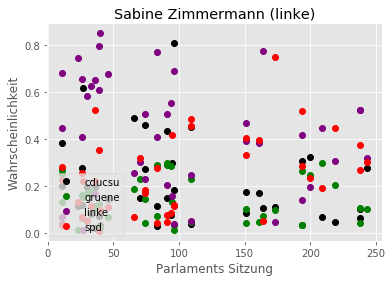

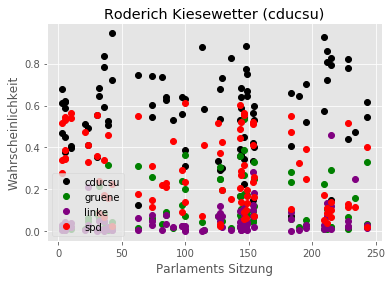

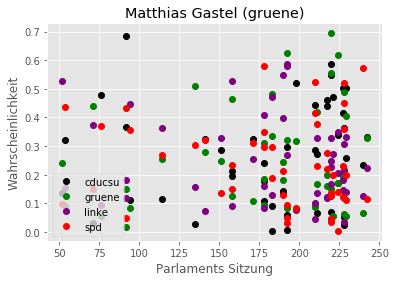

In [67]:
import matplotlib
matplotlib.style.use('ggplot')
import pylab as plt

# Wir betrachten nur die letzte Legislaturperiode
wahlperiode = 18
savepath = os.path.join(DATADIR,'sprecher-timeseries-{}'.format(wahlperiode))
if not os.path.exists(savepath): 
    os.mkdir(savepath)

# for sprecher in alle_sprecher:
for sprecher in ['Sabine Zimmermann', 'Roderich Kiesewetter', 'Matthias Gastel']:

    traindf = df[(df['sprecher']!=sprecher) & (df['wahlperiode']==wahlperiode)]
    testdf = df[(df['sprecher']==sprecher) & (df['wahlperiode']==wahlperiode)].sort_values(['sitzung'])

    if (len(traindf) > 10) and (len(testdf) > 10):
        partei = testdf.partei.values[0]
        tmpclf = clf.best_estimator_.fit(traindf.text, traindf.partei)
        predictions = tmpclf.predict_proba(testdf.text)
        plt.figure()
        for partei_idx in range(predictions.shape[-1]):
            color = partei_farben[tmpclf.classes_[partei_idx]]
            plt.plot(testdf.sitzung, predictions[:, partei_idx],"o",color=color)
            plt.title("{} ({})".format(sprecher,partei))
            plt.savefig(os.path.join(savepath, sprecher + ".pdf"))
            plt.xlabel('Parlaments Sitzung')
            plt.ylabel('Wahrscheinlichkeit')
            plt.legend(tmpclf.classes_, loc='lower left')
